In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback
from sklearn import preprocessing
from ucimlrepo import fetch_ucirepo 

import seaborn as sns

2024-08-04 22:09:17.335803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
dataset_name = "splice"

In [5]:
import seaborn as sns

In [6]:
import matplotlib
matplotlib.__version__

'3.7.1'

In [7]:
# fetch dataset 
credit_approval = fetch_ucirepo(id=69) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 69, 'name': 'Molecular Biology (Splice-junction Gene Sequences)', 'repository_url': 'https://archive.ics.uci.edu/dataset/69/molecular+biology+splice+junction+gene+sequences', 'data_url': 'https://archive.ics.uci.edu/static/public/69/data.csv', 'abstract': 'Primate splice-junction gene sequences (DNA) with associated imperfect domain theory', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Sequential', 'Domain-Theory'], 'num_instances': 3190, 'num_features': 60, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': ['instancename'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5M888', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Problem Description: \r\n      \r\nSplice junctions are points on a DNA sequence at which `superfluous\' DNA is removed during the process of protein creation in

In [8]:
is_receptor_or_donor = (y["class"] != "N").values
y = y[is_receptor_or_donor]
X = X.iloc[is_receptor_or_donor]

In [9]:
categorical_cols = X.columns
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(X, columns=categorical_cols)
# Initialize a scaler
scaler = preprocessing.StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = X.fillna(0)

# to numpy
X = X.values

In [10]:
set(y["class"])

{'EI', 'IE'}

In [11]:
X.shape

(1535, 284)

In [12]:
y.shape

(1535, 1)

In [13]:
y

,class
0,EI
1,EI
2,EI
3,EI
4,EI
...,...
1530,IE
1531,IE
1532,IE
1533,IE


In [14]:
y = np.array([0.0 if elem == "IE" else 1.0 for elem in y["class"]])

In [15]:
from sklearn import model_selection

In [16]:
X, Xtest, y, ytest = model_selection.train_test_split(X, y)

In [17]:
y.mean()

0.4917463075586447

In [18]:
ytest.sum()

201.0

## Specify learning algorithms

In [19]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(f"{X=}")
    #print(f"{theta.T=}")
    #print(f"{y=}")
    y = sigmoid(y)
    #print(f"{y=}")
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    #print(f"{p=}")
    #print(f"{y=}")
    #print(f"{l=}")
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + np.exp(u)) ** 2) * np.log1p(np.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [20]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=1,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 6600
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_random":
            """
            Added to address the reviewer's comment:
            The authors conduct experiments on "uniform sampling" + "constant step size", "loss-based sampling" + "constant step size", 
            and "loss-based sampling" + "Polyak step size" to verify the effectiveness of the approach of loss-based sampling. For 
            completeness, it is necessary to present the performance of using "uniform sampling" + "Polyak step size" in the numerical experiments.
            """
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = pz0
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 10 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [21]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [22]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [23]:
hyperparam_per_algo["absloss"] = {"eta": 0.1}
hyperparam_per_algo["random"] = {"eta": 0.1}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.9,
    "omega": 1.0
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.9,
    "omega": 1.10
}

In [24]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 10, 'kappa0': 0.9, 'eta': 0.1, 'omega': 1.0},
 'polyak_exponent': {'kappa': 10,
  'kappa0': 0.9,
  'eta': 0.1,
  'polyakexp': 0.9951814804061615,
  'omega': 1.1},
 'absloss': {'eta': 0.1},
 'random': {'eta': 0.1}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [25]:
X

array([[-0.51623798,  1.58511382, -0.02553215, ..., -0.73458754,
        -0.02553215, -0.53441055],
       [-0.51623798, -0.63086952, -0.02553215, ..., -0.73458754,
        -0.02553215, -0.53441055],
       [ 1.93709111, -0.63086952, -0.02553215, ..., -0.73458754,
        -0.02553215, -0.53441055],
       ...,
       [-0.51623798,  1.58511382, -0.02553215, ..., -0.73458754,
        -0.02553215,  1.87122053],
       [-0.51623798, -0.63086952, -0.02553215, ..., -0.73458754,
        -0.02553215, -0.53441055],
       [-0.51623798, -0.63086952, -0.02553215, ..., -0.73458754,
        -0.02553215,  1.87122053]])

In [26]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 1151 iterations with d=284
loss: 0.6301450206469373, train loss: 0.6931471805599453, ||theta||_1: 9.996326926513948 acc: 0.5
loss: 0.5052501360958545, train loss: 0.8481023991003127, ||theta||_1: 18.94668127598431 acc: 0.0
loss: 0.4869473770190595, train loss: 0.16412738537491584, ||theta||_1: 27.03715745060371 acc: 1.0
loss: 0.3423805794937011, train loss: 0.03654914719804667, ||theta||_1: 29.893574917187976 acc: 1.0
loss: 0.3662257882475453, train loss: 0.00173208686305907, ||theta||_1: 32.23093969159724 acc: 1.0
loss: 0.4658696245910403, train loss: 0.006047394198907879, ||theta||_1: 34.61370991832547 acc: 1.0
loss: 0.3992210355448478, train loss: 0.011858173693651483, ||theta||_1: 36.65832434985751 acc: 1.0
loss: 0.35765116158733035, train loss: 0.006135944069678077, ||theta||_1: 35.163258718363494 acc: 1.0
loss: 0.2627224702698722, train loss: 0.0005823027459249773, ||theta||_1: 34.84212912886789 acc: 1.0
loss: 0.25798682122110034, train loss: 0.19

loss: 0.24318270782529738, train loss: 0.008813669275836227, ||theta||_1: 36.72948595311749 acc: 1.0
loss: 0.24556006324648236, train loss: 0.0012209898547615905, ||theta||_1: 35.163287256640345 acc: 1.0
loss: 0.22086651583395386, train loss: 1.2790174600243356, ||theta||_1: 34.199074594249694 acc: 0.0
loss: 0.3201206720836194, train loss: 0.029008505861537203, ||theta||_1: 37.6532624743058 acc: 1.0
loss: 0.29986670113449426, train loss: 0.34988880766927427, ||theta||_1: 39.13344628396091 acc: 1.0
loss: 0.29986670113449426, train loss: 0.010149511938544699, ||theta||_1: 39.13344628396091 acc: 1.0
loss: 0.2668591082483558, train loss: 0.007102402043702374, ||theta||_1: 39.29162962799897 acc: 1.0
loss: 0.20952666479414458, train loss: 0.0008962202350106202, ||theta||_1: 39.356545734788924 acc: 1.0
loss: 0.20288989428268236, train loss: 0.0036738401762982462, ||theta||_1: 39.41168645276554 acc: 1.0
loss: 0.18595552128697493, train loss: 0.006964994819014129, ||theta||_1: 38.60039863412653

In [27]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [28]:
absloss_mean_sampling_prob

0.15484155632196486

In [29]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 1151 iterations with d=284
loss: 0.6301450206469373, train loss: 0.6931471805599453, ||theta||_1: 9.996326926513948 acc: 0.5
loss: 0.5519139117309434, train loss: 0.8527270100224386, ||theta||_1: 14.159524338022498 acc: 0.0
loss: 0.5645770419019978, train loss: 0.3340171300976564, ||theta||_1: 15.75488011183033 acc: 1.0
loss: 0.451669262006513, train loss: 3.0814133630138905, ||theta||_1: 23.207824918091177 acc: 0.0
loss: 0.451669262006513, train loss: 0.16972943844254393, ||theta||_1: 23.207824918091177 acc: 1.0
loss: 0.34721127554599374, train loss: 0.07506115760964566, ||theta||_1: 19.244527240819373 acc: 1.0
loss: 0.35608667353084505, train loss: 0.04711754527782512, ||theta||_1: 22.184600884271173 acc: 1.0
loss: 0.34410338829628734, train loss: 0.008447140312819767, ||theta||_1: 20.322477334884514 acc: 1.0
loss: 0.3299095928930252, train loss: 0.11340025195423649, ||theta||_1: 18.78028582024924 acc: 1.0
loss: 0.32658962388246887, train loss: 1.06320

loss: 0.3980312505504863, train loss: 0.3358296123191986, ||theta||_1: 19.558290298962177 acc: 1.0
loss: 0.3836731019401549, train loss: 0.42196048012639553, ||theta||_1: 22.014860396549576 acc: 1.0
loss: 0.3833070441449313, train loss: 0.000318034048315959, ||theta||_1: 21.037612520388613 acc: 1.0
loss: 0.3833070441449313, train loss: 1.041733747853236, ||theta||_1: 21.037612520388613 acc: 0.0
loss: 0.3833070441449313, train loss: 0.0619070361592555, ||theta||_1: 21.037612520388613 acc: 1.0
loss: 0.3833070441449313, train loss: 0.2535527590442438, ||theta||_1: 21.037612520388613 acc: 1.0
loss: 0.3833070441449313, train loss: 1.200160529109747, ||theta||_1: 21.037612520388613 acc: 0.0
loss: 0.3723275575324186, train loss: 1.1988032061876543, ||theta||_1: 20.32512218035362 acc: 0.0
loss: 0.4853307290940672, train loss: 0.37400083786718996, ||theta||_1: 22.592586949369778 acc: 1.0
loss: 0.42731167860486613, train loss: 0.05351700715602804, ||theta||_1: 21.603078585878905 acc: 1.0
loss: 0

In [30]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5022550647044861, train loss: 0.4707978116464183, ||theta||_1: 15.34609621994289 acc: 1.0
loss: 0.41752204928824893, train loss: 0.03818724507235355, ||theta||_1: 16.195138324832133 acc: 1.0
loss: 0.3926942979928849, train loss: 0.025677848795457755, ||theta||_1: 15.87229935220714 acc: 1.0
loss: 0.39279667231685345, train loss: 0.06705168284125299, ||theta||_1: 15.19527254535852 acc: 1.0
loss: 0.3830254196558398, train loss: 0.0764930550506193, ||theta||_1: 19.398099353305373 acc: 1.0
loss: 0.3651240326202128, train loss: 0.004174616726948255, ||theta||_1: 18.083595937691854 acc: 1.0
loss: 0.368531040338719, train loss: 1.0055554022426183, ||theta||_1: 16.341551738319183 a

loss: 0.26453011725989745, train loss: 0.020740115136081334, ||theta||_1: 18.18022740746568 acc: 1.0
loss: 0.2554232040804451, train loss: 0.20631796587319484, ||theta||_1: 17.935676836110627 acc: 1.0
loss: 0.2629650670995491, train loss: 0.18867211760583527, ||theta||_1: 16.32985091573201 acc: 1.0
loss: 0.2576155043072688, train loss: 0.022134953869442153, ||theta||_1: 15.38376745073873 acc: 1.0
loss: 0.25811568177949457, train loss: 0.4376273433365749, ||theta||_1: 16.48250030446402 acc: 1.0
loss: 0.2542890084519293, train loss: 0.09704322184364964, ||theta||_1: 15.9176220150073 acc: 1.0
loss: 0.27101556581645264, train loss: 1.4157410711641156, ||theta||_1: 14.794497746257072 acc: 0.0
loss: 0.27101556581645264, train loss: 0.22622890067124263, ||theta||_1: 14.794497746257072 acc: 1.0
loss: 0.28524879233844375, train loss: 0.3698809384603608, ||theta||_1: 15.512623880085929 acc: 1.0
loss: 0.2610871750425002, train loss: 0.06556193156389879, ||theta||_1: 15.09729865052977 acc: 1.0
los

In [31]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 1151 iterations with d=284
loss: 0.6301450206469373, train loss: 0.6931471805599453, ||theta||_1: 9.996326926513948 acc: 0.5
loss: 0.4813074816215533, train loss: 0.44206061727303364, ||theta||_1: 13.967764087525426 acc: 1.0
loss: 0.4937018949690228, train loss: 0.6006375846885809, ||theta||_1: 20.329817948715 acc: 1.0
loss: 0.3953249674686468, train loss: 0.29381668749365475, ||theta||_1: 25.47532717415492 acc: 1.0
loss: 0.44511697979512216, train loss: 0.014640228081967065, ||theta||_1: 27.663815950643496 acc: 1.0
loss: 0.6289494365457652, train loss: 0.08913657512603863, ||theta||_1: 32.21763085507024 acc: 1.0
loss: 0.5415498789696341, train loss: 0.005929735991541027, ||theta||_1: 35.06192490076053 acc: 1.0
loss: 0.49404436245621414, train loss: 0.007962220077285885, ||theta||_1: 42.41828004688573 acc: 1.0
loss: 0.3202386854975981, train loss: 2.621001445886603e-05, ||theta||_1: 40.77706786277568 acc: 1.0
loss: 0.3202386854975981, train loss: 0.0013

loss: 0.29933590672458804, train loss: 0.05623168611774451, ||theta||_1: 35.956883987977626 acc: 1.0
loss: 0.29933590672458804, train loss: 0.06792682514211813, ||theta||_1: 35.956883987977626 acc: 1.0
loss: 0.24673636670800783, train loss: 0.8914974433551833, ||theta||_1: 36.46628588022041 acc: 0.0
loss: 0.24673636670800783, train loss: 0.15028594343334437, ||theta||_1: 36.46628588022041 acc: 1.0
loss: 0.252084486112884, train loss: 0.00391393074088408, ||theta||_1: 35.24043569832193 acc: 1.0
loss: 0.252084486112884, train loss: 0.035872396965586514, ||theta||_1: 35.24043569832193 acc: 1.0
loss: 0.3042704390889196, train loss: 1.8015348104034194e-07, ||theta||_1: 36.11273213713734 acc: 1.0
loss: 0.2716124723181315, train loss: 0.0024252036974143874, ||theta||_1: 33.600325243522924 acc: 1.0
loss: 0.25395285589792665, train loss: 0.10431541851171938, ||theta||_1: 32.33598571457877 acc: 1.0
loss: 0.22019124315389516, train loss: 0.9963905101424668, ||theta||_1: 30.247451910326923 acc: 0.

In [32]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

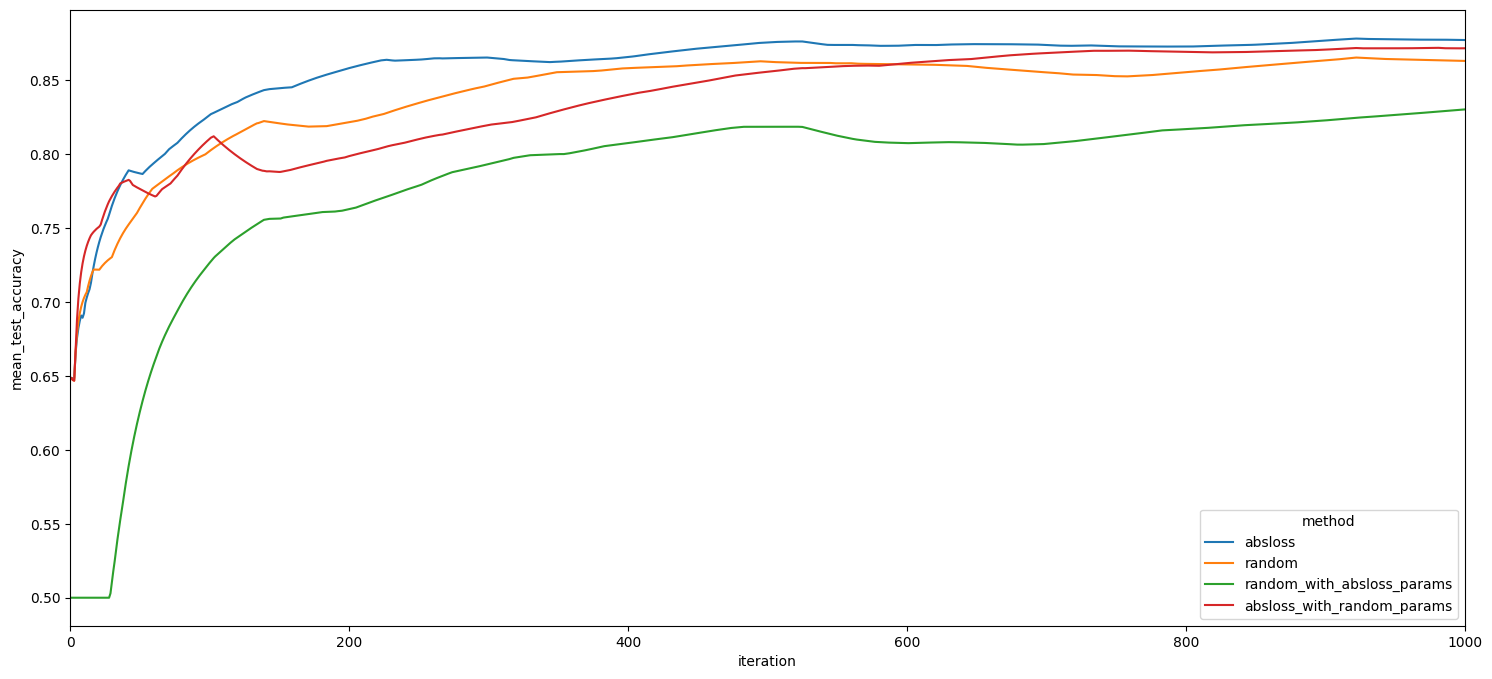

In [33]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

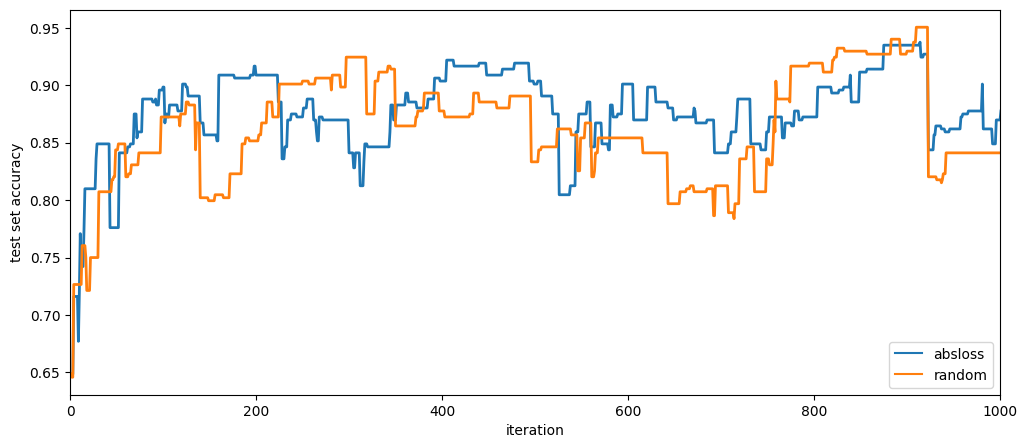

In [34]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig(f"figure_8a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

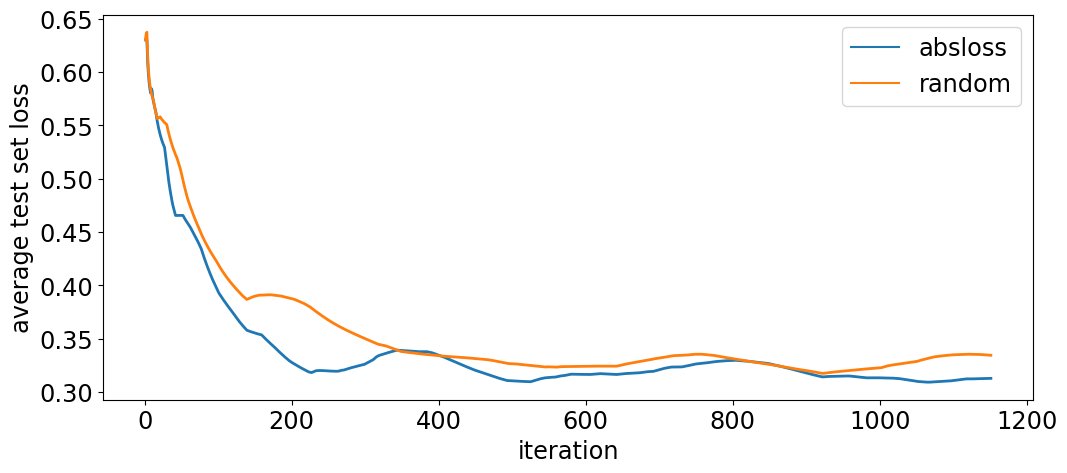

In [35]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_7a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

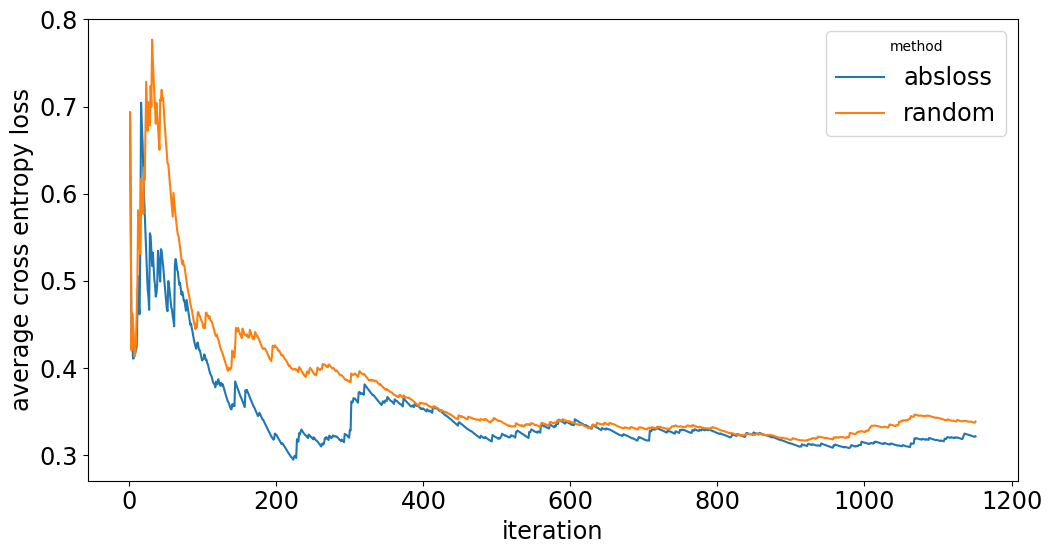

In [36]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

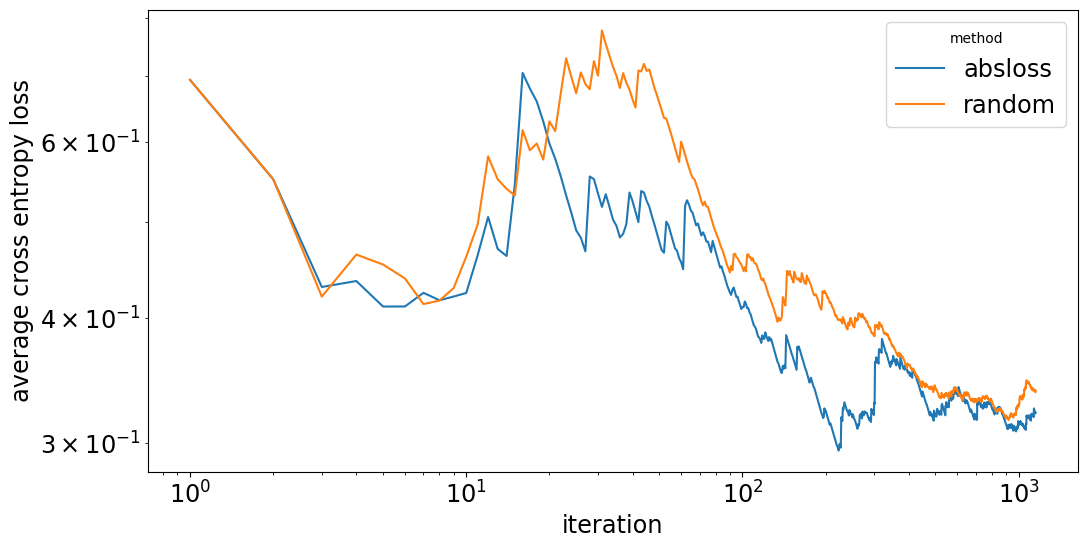

In [37]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [38]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6945475115924055, train loss: 0.23995497773899216, ||theta||_1: 9.725533183543678 acc: 1.0
loss: 0.6945475115924055, train loss: 0.8518845758864101, ||theta||_1: 9.725533183543678 acc: 0.0
loss: 0.49343309812272906, train loss: 0.29078993609194154, ||theta||_1: 14.296938867959465 acc: 1.0
loss: 0.49343309812272906, train loss: 0.7710825600200034, ||theta||_1: 14.296938867959465 acc: 0.0
loss: 0.5074548266584112, train loss: 0.03892513278333948, ||theta||_1: 13.176182959707166 acc: 1.0
loss: 0.45186083848791575, train loss: 0.3585813616902571, ||theta||_1: 14.208430103454539 acc: 1.0
loss: 0.4167090996598102, train loss: 1.8296375515079975, ||theta||_1: 19.383923256725346 acc: 0.0
loss: 0.3890499896842523, train loss: 0.10209040488866955, ||theta||_1: 16.953331002327886 acc: 1.0
loss: 0.3515652856642617, train loss: 0.36526146283

loss: 0.27117235391741334, train loss: 1.237504565097879, ||theta||_1: 12.527215281515128 acc: 0.0
loss: 0.306039263523459, train loss: 0.002433605136084616, ||theta||_1: 15.401486021465823 acc: 1.0
loss: 0.30544481261140005, train loss: 0.08481091706558216, ||theta||_1: 12.949595774151202 acc: 1.0
loss: 0.29950365053092126, train loss: 0.7221398267156762, ||theta||_1: 13.171771816120092 acc: 0.0
loss: 0.3043471179235511, train loss: 0.470239773430901, ||theta||_1: 11.343056233391495 acc: 1.0
loss: 0.2974532909740097, train loss: 0.16143712739254357, ||theta||_1: 11.293263328609068 acc: 1.0
loss: 0.2824846960820346, train loss: 0.6736149222772724, ||theta||_1: 13.386015885999013 acc: 1.0
loss: 0.28120452390574174, train loss: 0.3751843195785987, ||theta||_1: 12.142606124587363 acc: 1.0
loss: 0.30330898486039914, train loss: 0.20756940511841665, ||theta||_1: 13.726147972706318 acc: 1.0
loss: 0.2926371394831788, train loss: 0.1985585993056358, ||theta||_1: 12.193999874767549 acc: 1.0
los

In [39]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[4.572214245083309, 2.2861071225416545, 1.3763736343722217, 0.6881868171861109]

In [40]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [41]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [42]:
empirical_pzs

[5.5185942943647176e-05,
 0.3372421788342131,
 0.32317758565954285,
 0.4317711979042309]

In [43]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [44]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [45]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs   
polyak_exponent  0.7         0.032044    0.025484
                             0.053267    1.051663
                             0.060007    1.515861
                             0.080417    0.294855
                             0.085783    0.686149
                                           ...   
                 4.6         0.000127    0.693147
random           0.7         0.431771    0.335465
                 1.4         0.323178    0.312639
                 2.3         0.337242    0.338726
                 4.6         0.000055    0.693147
Name: train_loss, Length: 3791, dtype: float64

In [46]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs   
polyak_exponent  0.7         0.032044    0.419799
                             0.053267    0.320788
                             0.060007    0.315617
                             0.080417    0.346060
                             0.085783    0.313609
                                           ...   
                 4.6         0.000127    0.693147
random           0.7         0.431771    0.330842
                 1.4         0.323178    0.269343
                 2.3         0.337242    0.314628
                 4.6         0.000055    0.693147
Name: mean_train_loss, Length: 3791, dtype: float64

Polyak exp value 4.6 has rows (2302, 16)
Polyak exp value 2.3 has rows (2302, 16)
Polyak exp value 1.4 has rows (2302, 16)
Polyak exp value 0.7 has rows (2302, 16)


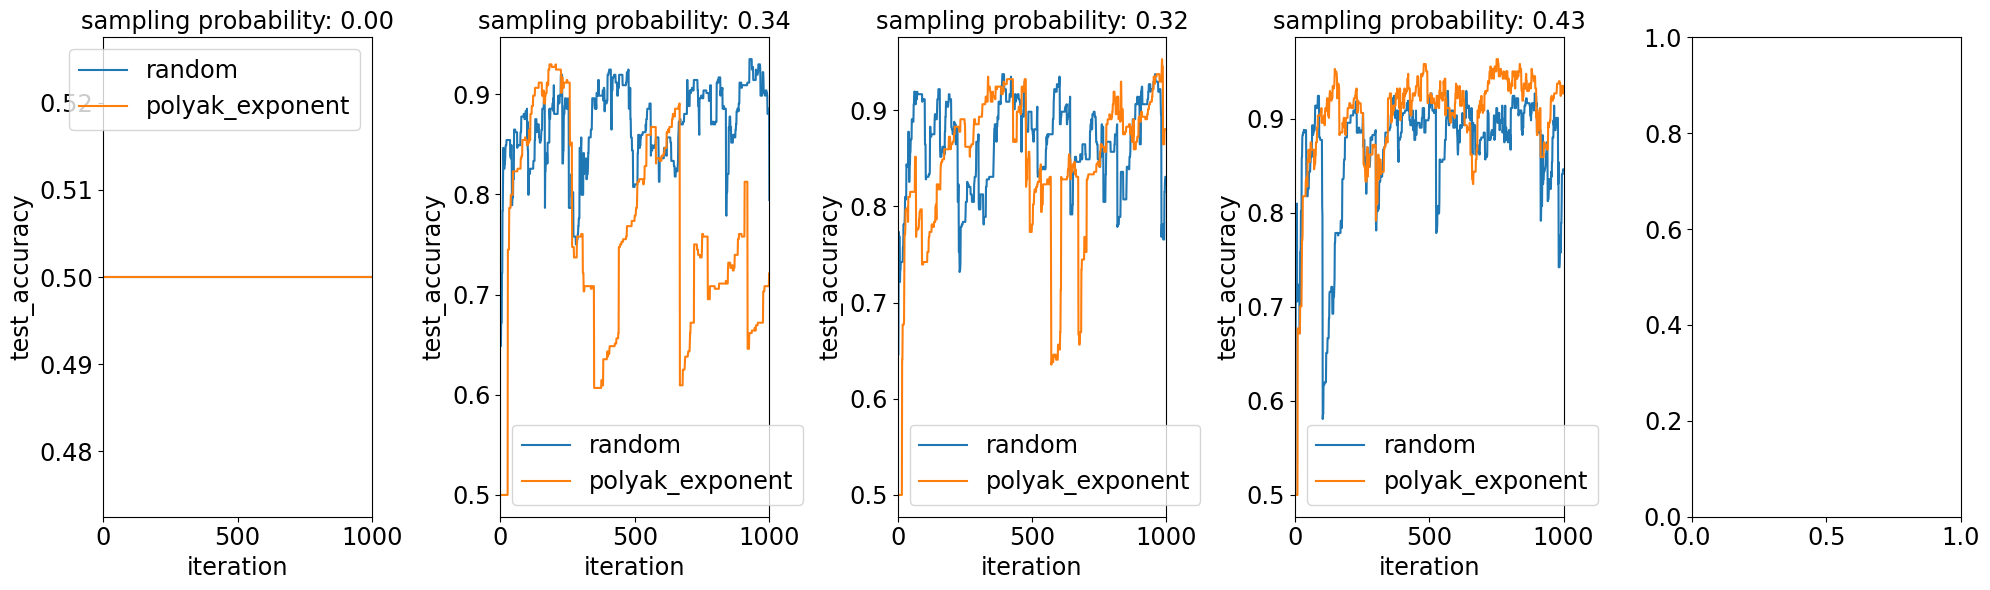

In [47]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 4.6 has rows (2302, 16)
Polyak exp value 2.3 has rows (2302, 16)
Polyak exp value 1.4 has rows (2302, 16)
Polyak exp value 0.7 has rows (2302, 16)


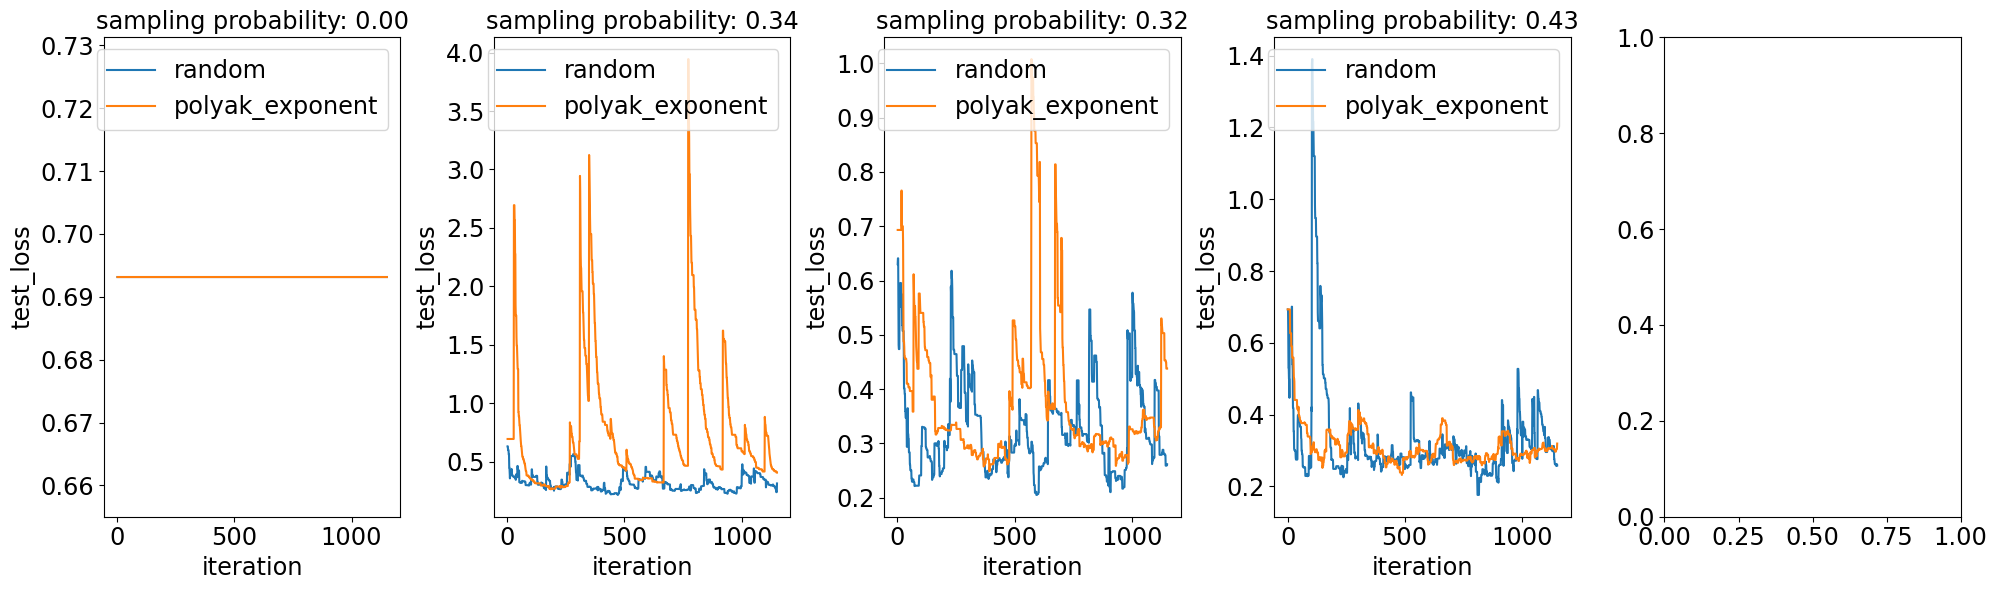

In [48]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [49]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

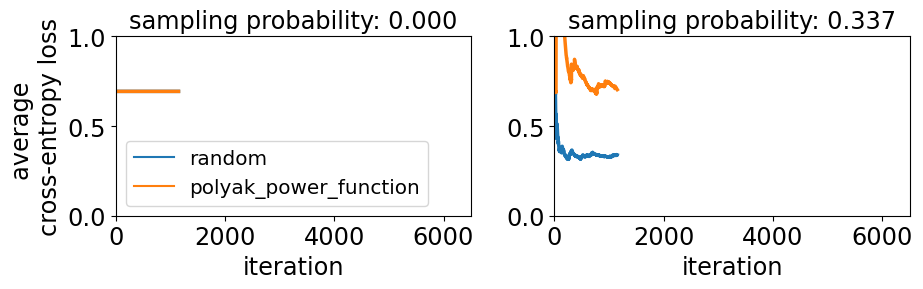

In [50]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

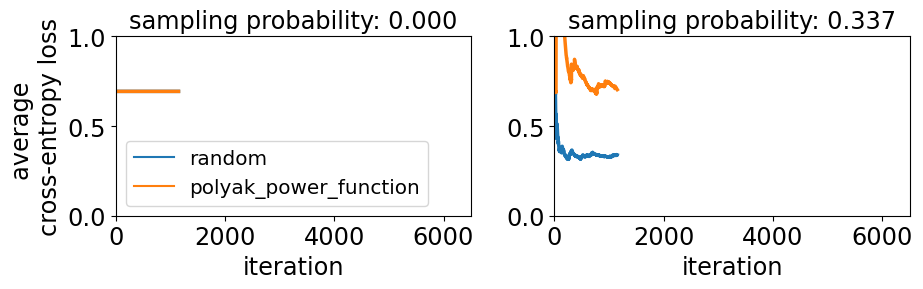

In [51]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

5.5185942943647176e-05
Polyak exp value 4.6 has rows (2302, 16)
0.3372421788342131
Polyak exp value 2.3 has rows (2302, 16)
0.32317758565954285
Polyak exp value 1.4 has rows (2302, 16)
0.4317711979042309
Polyak exp value 0.7 has rows (2302, 16)


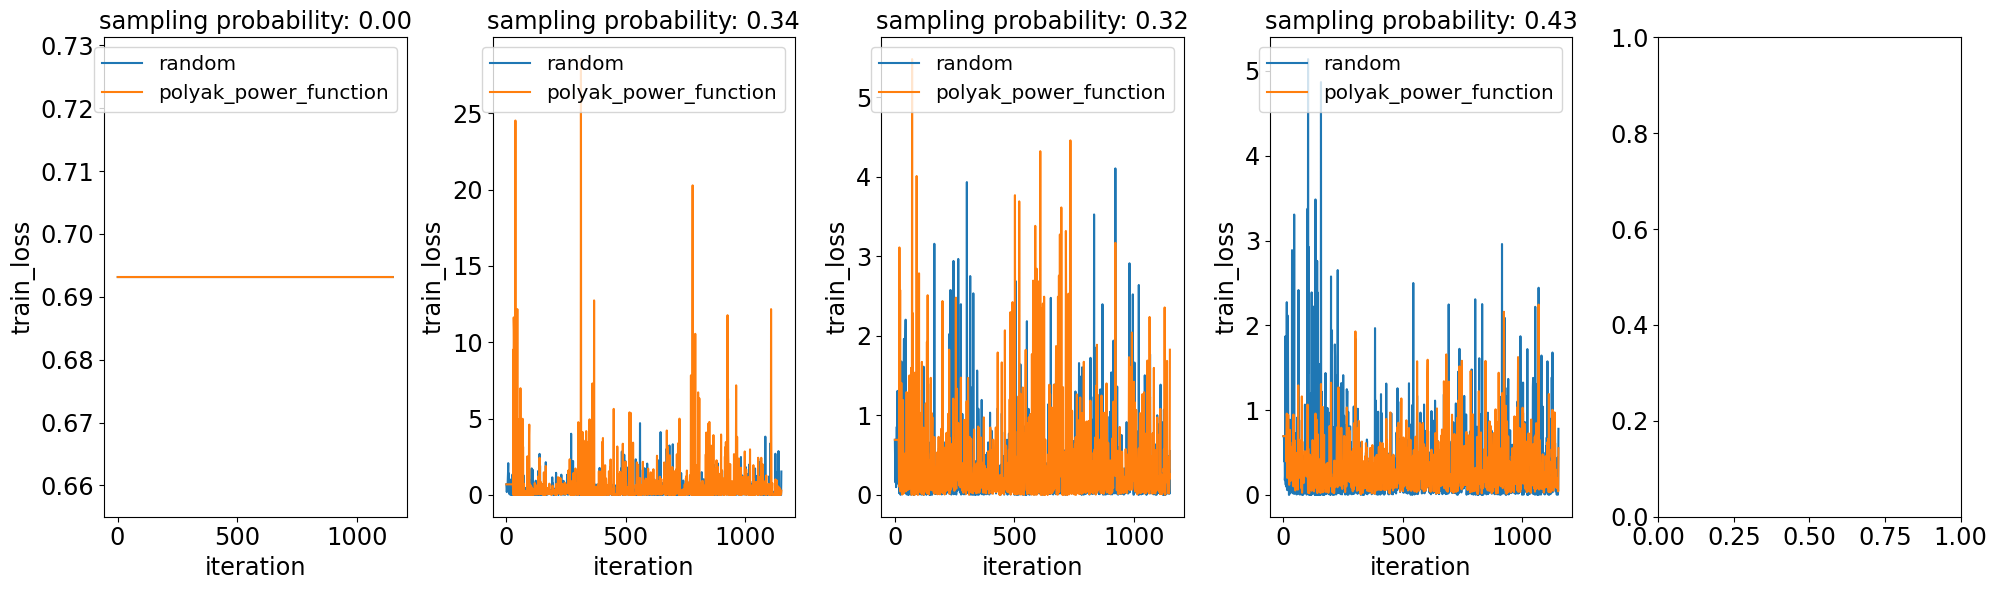

In [52]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

5.5185942943647176e-05
Polyak exp value 4.6 has rows (2302, 16)
0.3372421788342131
Polyak exp value 2.3 has rows (2302, 16)
0.32317758565954285
Polyak exp value 1.4 has rows (2302, 16)
0.4317711979042309
Polyak exp value 0.7 has rows (2302, 16)


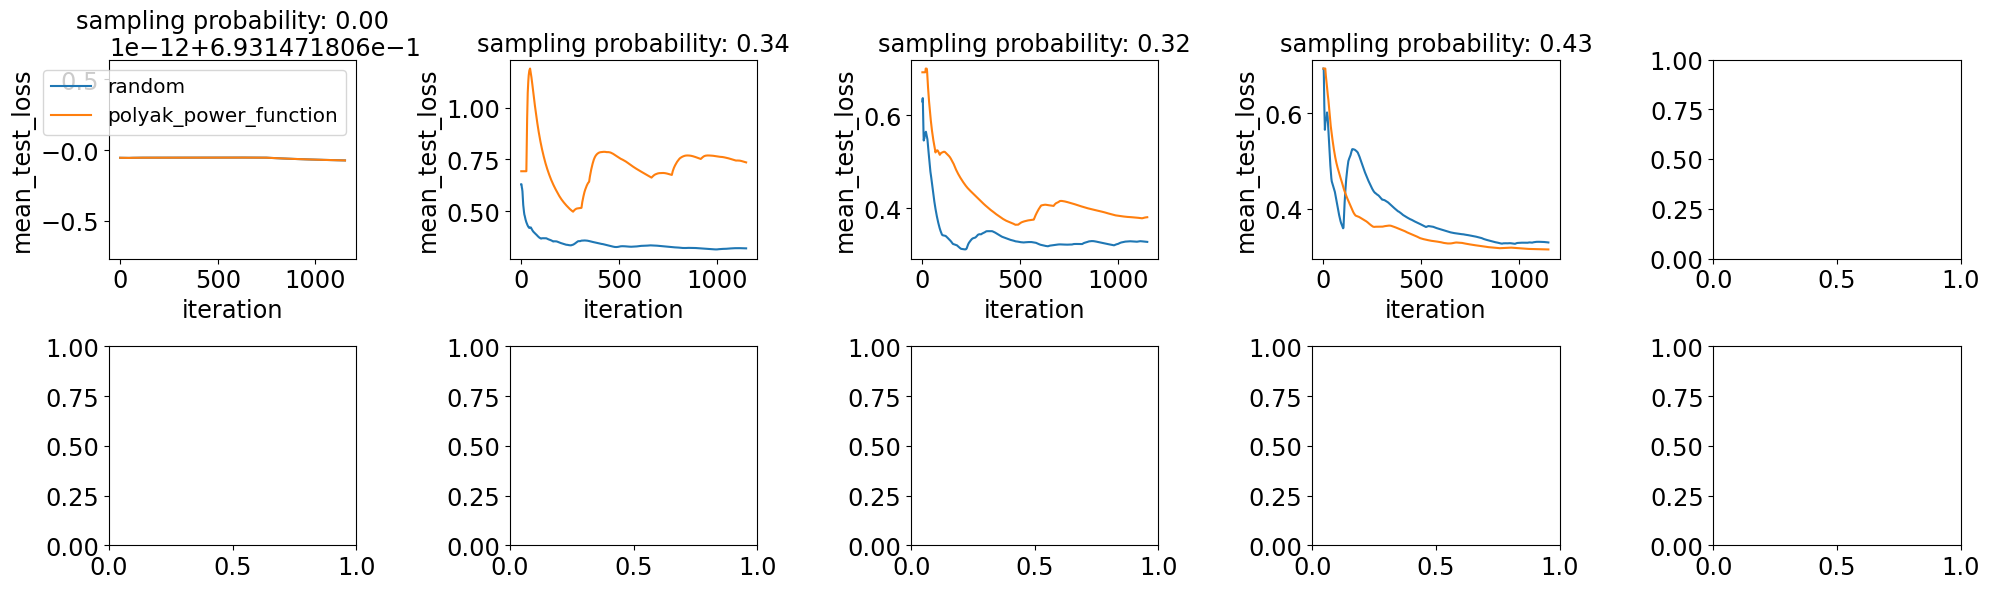

In [53]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [54]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 10, 'kappa0': 0.9, 'eta': 0.1, 'omega': 1.0}

In [55]:
results_polyak_random = train_model(
    X, y, Xtest, ytest, mode="polyak_random", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"] | {"pz0": absloss_mean_sampling_prob}
)

Training with algorithm polyak_random: 1151 iterations with d=284
loss: 0.6282960221912913, train loss: 0.6931471805599453, ||theta||_1: 7.731416167692624 acc: 0.5
loss: 0.432159375891275, train loss: 1.2468529073324148, ||theta||_1: 13.879381407129767 acc: 0.0
loss: 0.3927564232713485, train loss: 0.29488428924415305, ||theta||_1: 15.17229233554913 acc: 1.0
loss: 0.41389075890287746, train loss: 0.17409516307896195, ||theta||_1: 16.879558817971336 acc: 1.0
loss: 0.3788982134263665, train loss: 0.37474304653393875, ||theta||_1: 16.77370851971736 acc: 1.0
loss: 0.3930026847680251, train loss: 0.02282336939006684, ||theta||_1: 17.01698075729261 acc: 1.0
loss: 0.3930026847680251, train loss: 0.0076199761555220845, ||theta||_1: 17.01698075729261 acc: 1.0
loss: 0.37362472807346875, train loss: 0.0033225266763479426, ||theta||_1: 18.19252046469935 acc: 1.0
loss: 0.35260828419775453, train loss: 0.0045180583932601616, ||theta||_1: 18.818913033795425 acc: 1.0
loss: 0.38213169151255605, train l

loss: 0.2935127321655617, train loss: 0.5651319942495147, ||theta||_1: 20.158834143706883 acc: 1.0
loss: 0.2935127321655617, train loss: 0.02135921594856158, ||theta||_1: 20.158834143706883 acc: 1.0
loss: 0.27046801509802293, train loss: 0.4868380526872828, ||theta||_1: 20.233881027059677 acc: 1.0
loss: 0.2399876418065154, train loss: 0.0060142600403493215, ||theta||_1: 19.86736246122483 acc: 1.0
loss: 0.2111390400662326, train loss: 0.6078129816363996, ||theta||_1: 19.187598715394337 acc: 1.0
loss: 0.2111390400662326, train loss: 0.24343313282573525, ||theta||_1: 19.187598715394337 acc: 1.0
loss: 0.21298512063829222, train loss: 0.2026130489442962, ||theta||_1: 19.440300492488873 acc: 1.0
loss: 0.20405945319190164, train loss: 0.13901536281510649, ||theta||_1: 18.688290617975206 acc: 1.0
loss: 0.20475307594902548, train loss: 0.1046865684655341, ||theta||_1: 17.533748112390313 acc: 1.0
loss: 0.20247003609630754, train loss: 0.02791670314151733, ||theta||_1: 17.048817607491245 acc: 1.0

In [56]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 1151 iterations with d=284
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5656028351752872, train loss: 0.5390712671126054, ||theta||_1: 4.681903649463622 acc: 1.0
loss: 0.42019732107371704, train loss: 0.4441306737483161, ||theta||_1: 7.738170225319039 acc: 1.0
loss: 0.3801470596450403, train loss: 0.37159042146045085, ||theta||_1: 7.329984434151044 acc: 1.0
loss: 0.31649758075410966, train loss: 0.2874518083022048, ||theta||_1: 10.355655429764276 acc: 1.0
loss: 0.28857397037598176, train loss: 0.051702879155061846, ||theta||_1: 11.493356147837254 acc: 1.0
loss: 0.28433674622132016, train loss: 0.08549288565090137, ||theta||_1: 11.501789489869072 acc: 1.0
loss: 0.29356268693184046, train loss: 0.1400599409318999, ||theta||_1: 11.388409845992584 acc: 1.0
loss: 0.253690067322707, train loss: 0.013559277053533915, ||theta||_1: 20.382665267586077 acc: 1.0
loss: 0.2478380593842767, train loss: 0.3820663987

loss: 0.2477003108613682, train loss: 0.5678128872496333, ||theta||_1: 16.253070056856775 acc: 1.0
loss: 0.24448643100509168, train loss: 0.22028281023622803, ||theta||_1: 15.011935930959062 acc: 1.0
loss: 0.2483788094183693, train loss: 0.01247523527214824, ||theta||_1: 13.324898689997383 acc: 1.0
loss: 0.2675748135947638, train loss: 0.2995163664455511, ||theta||_1: 12.423390137291705 acc: 1.0
loss: 0.2675748135947638, train loss: 0.2030461952934324, ||theta||_1: 12.423390137291705 acc: 1.0
loss: 0.2675748135947638, train loss: 0.10115992761198318, ||theta||_1: 12.423390137291705 acc: 1.0
loss: 0.2675748135947638, train loss: 0.18520961930256252, ||theta||_1: 12.423390137291705 acc: 1.0
loss: 0.28530538432524705, train loss: 0.12721128503665244, ||theta||_1: 11.689674920290038 acc: 1.0
loss: 0.3052373268280653, train loss: 0.434807347114888, ||theta||_1: 11.91817280910055 acc: 1.0
loss: 0.3054483756679139, train loss: 0.338941051578842, ||theta||_1: 12.300521053817114 acc: 1.0
loss: 

In [57]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 10, 'kappa0': 0.9, 'eta': 0.1, 'omega': 0.84157028614901}


In [58]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

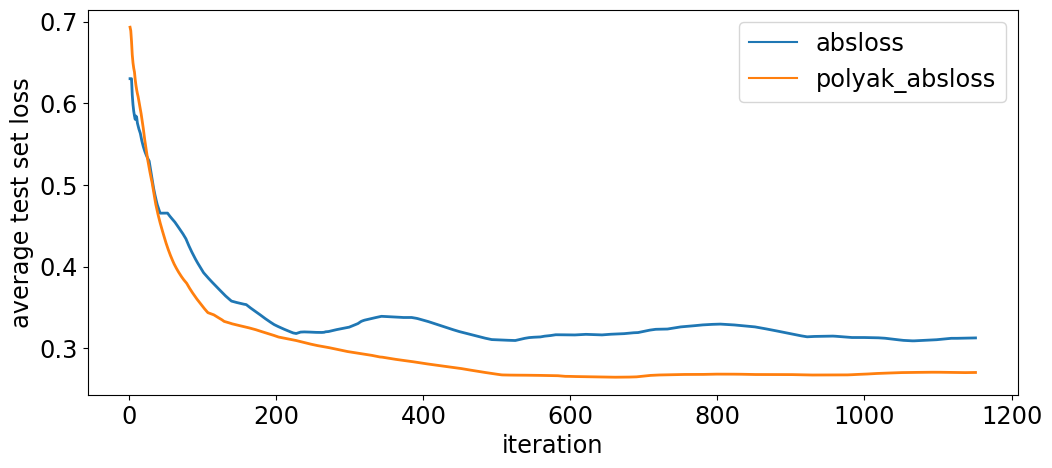

In [59]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig(f"figure_7b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

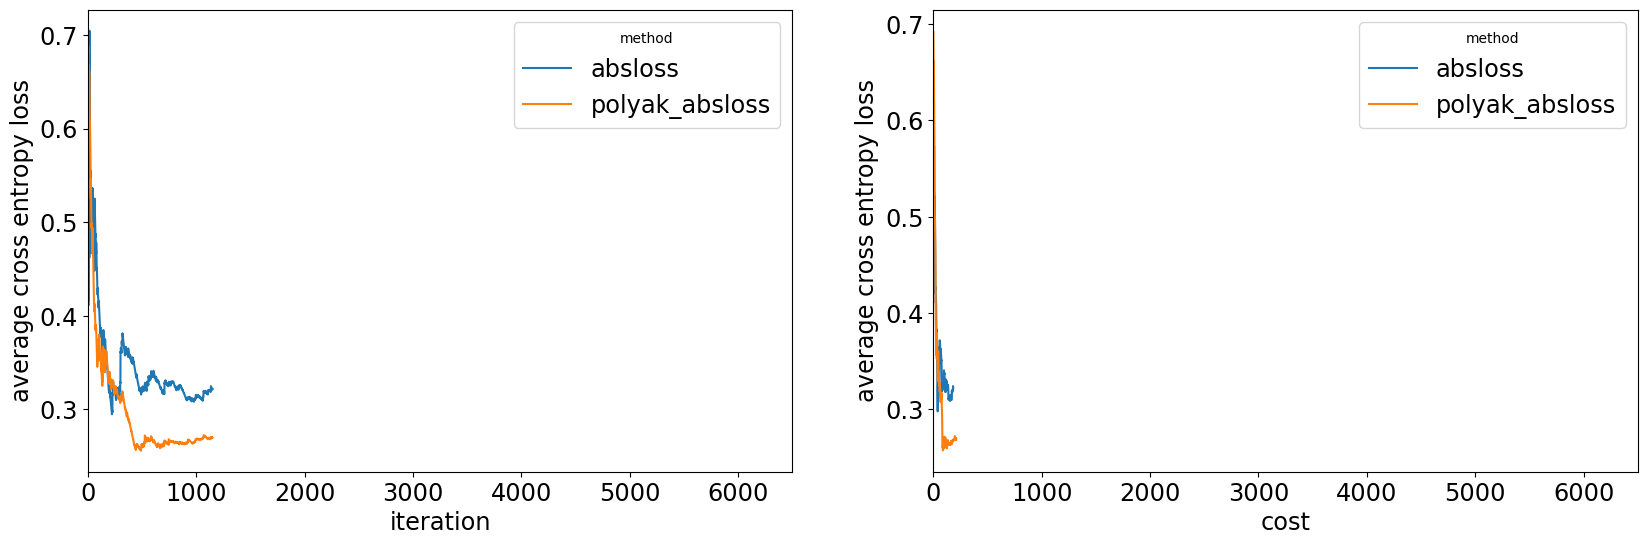

In [60]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

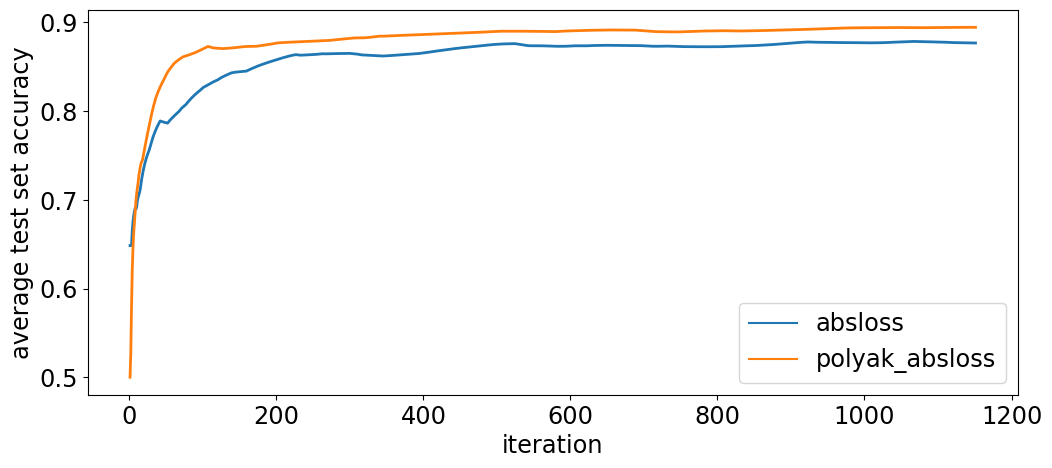

In [61]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_8b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

In [62]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
        "polyak_random": results_polyak_random
    }
)

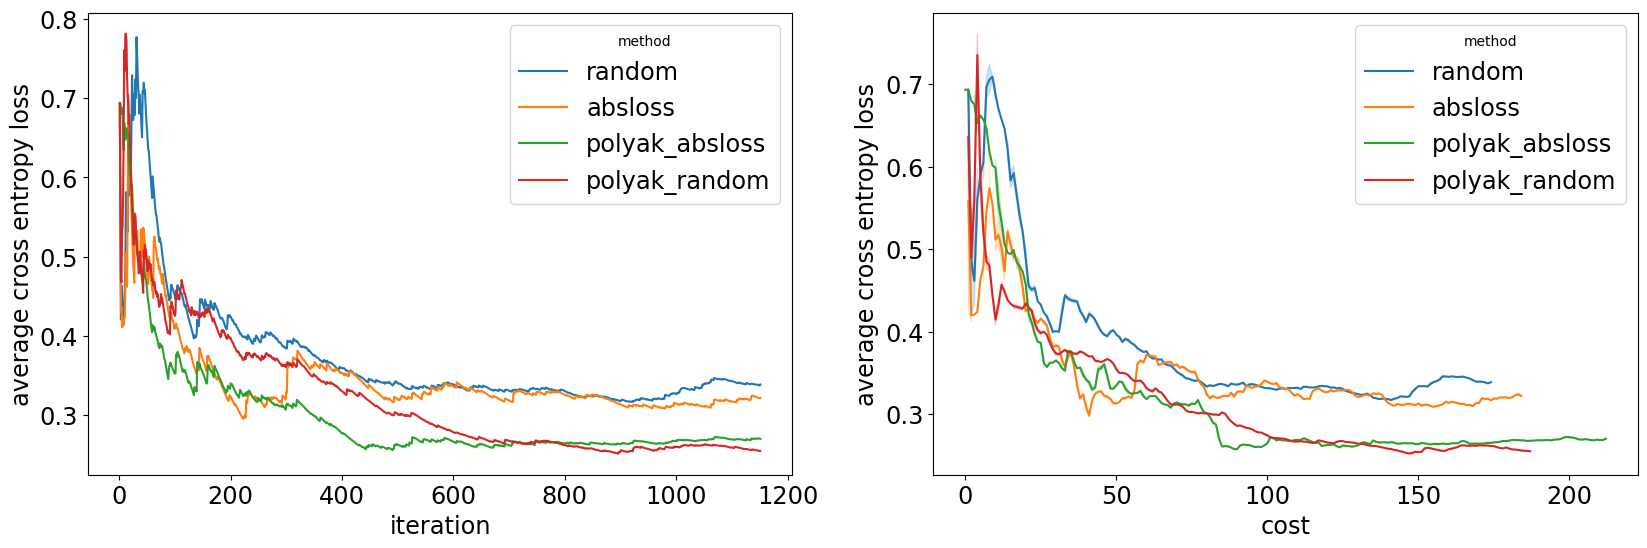

In [63]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

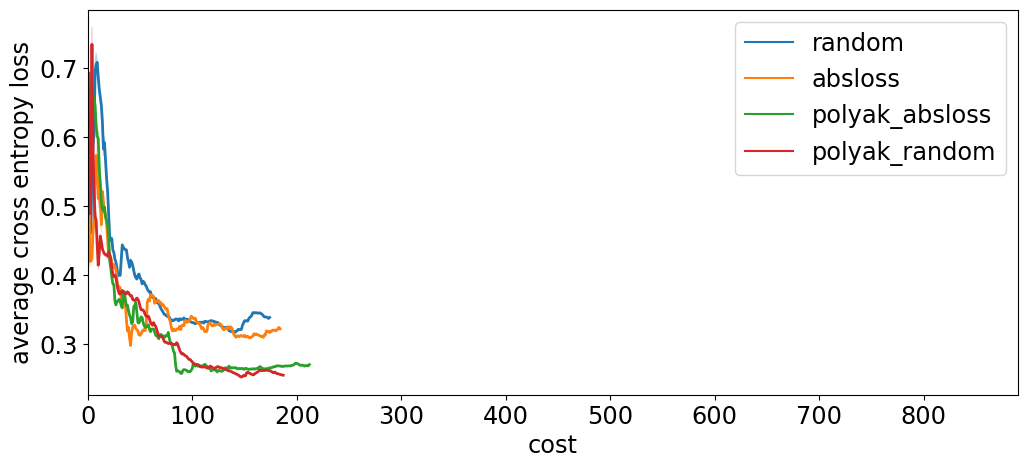

In [64]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_6_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

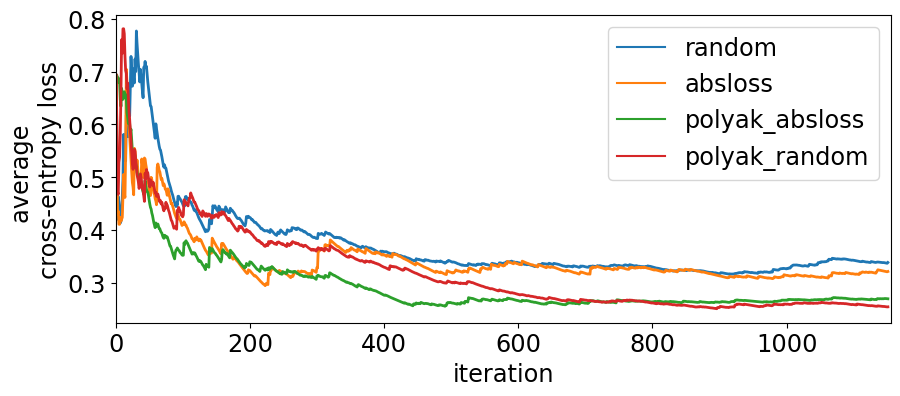

In [65]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')
ax.set_xlim((0, 1155))

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig(f"figure_3_icml_{dataset_name}_9.pdf", format="pdf", bbox_inches="tight")
